In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, time, timedelta
from scipy.optimize import brentq
from scipy.stats import norm
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')  # 过滤不必要的warnings
plt.rcParams["font.sans-serif"] = ['Hiragino Sans GB']  # set font
plt.rcParams["axes.unicode_minus"] = False  # solve "-"

In [2]:
''' 基本参数 '''
list_color = ['#044E7E', '#FF3333', '#367198', '#FF8080', '#81A6BE', '#FFB2B2', '#000000', '#999999','#666633','#996633']

begin_date = '2019-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  

index_code = '510050.SH' # 沪深300ETF代码

file_path = '/Users/tommylxt/Desktop/算法交易hw/PV_CV_Skew因子'

In [3]:
''' 指数期权数据 '''
data_1 = pd.read_pickle(f'{file_path}/ChinaOptionDescription.pkl')
data_2 = pd.read_pickle(f'{file_path}/ChinaOptionEODPrices.pkl')

''' 无风险利率数据 '''
df_bond_index = pd.read_excel(f'{file_path}/df_bond_index_pct.xlsx')
df_bond_index.rename(columns={'日期': '交易日期'}, inplace=True)
df_bond_rate = pd.read_excel(f'{file_path}/df_bond_rate.xlsx')
df_bond_rate.rename(columns={'日期': '交易日期', 'R': '无风险利率'}, inplace=True)

''' 指数数据 '''
df_index = pd.read_excel(f'{file_path}/df_510050.SH_data.xlsx')
df_index.rename(columns={'日期': '交易日期'}, inplace=True)

df_1 = pd.DataFrame(data_1)
df_2 = pd.DataFrame(data_2)

In [4]:
''' 期权数据整理 '''
# 筛选需要的数据
df_1.rename(columns = {
          'S_INFO_WINDCODE':'月合约wind代码', 'S_INFO_CODE':'月合约交易所编码',
          'S_INFO_NAME':'月合约全称', 'S_INFO_SCCODE':'期权wind代码','S_INFO_CALLPUT':'月合约类别',
          'S_INFO_STRIKEPRICE':'行权价格',
          'S_INFO_MONTH':'交割月份', 'S_INFO_MATURITYDATE':'到期日','S_INFO_FTDATE':'开始交易日',
          'S_INFO_LASTTRADINGDATE':'最后交易日', 'S_INFO_EXERCISINGEND':'最后行权日',
          'S_INFO_LDDATE':'最后交割日', 'S_INFO_LPRICE':'挂牌基准价',
          },inplace=True)


df_1 = df_1.loc[:, ['月合约wind代码', '月合约全称', '月合约类别', '行权价格',
                    '开始交易日', '最后交易日', '最后行权日', '挂牌基准价'
                   ]]

keywords=['华夏上证50ETF']
matched_df_1 = []

# 对每个关键词进行搜索
for keyword in keywords:
    # 过滤包含关键词的行
    matched_rows = df_1[df_1['月合约全称'].str.contains(keyword, na=False)]
    # 将匹配的DataFrame添加到列表中
    matched_df_1.append(matched_rows)

# 使用concat合并所有匹配的DataFrame
df_1 = pd.concat(matched_df_1, ignore_index=True)

# 筛选需要的数据
df_2.rename(columns = {
          'S_INFO_WINDCODE':'wind代码', 'TRADE_DT':'交易日期',
          'S_DQ_CLOSE':'收盘价','S_DQ_SETTLE':'结算价'
          },inplace=True)

df_2 = df_2.loc[:, ['wind代码', '交易日期', '收盘价', '结算价']]

unique_codes = df_1['月合约wind代码'].unique()

# 将df_2中的'月合约wind代码', '月合约全称', '月合约类别'三列合并到df_3
df_merged = df_2.merge(df_1[['月合约wind代码', '月合约全称', '月合约类别', '行权价格',
                             '开始交易日', '最后交易日', '最后行权日', '挂牌基准价']], 
                             left_on='wind代码', right_on='月合约wind代码', how='left')

# 修改月合约类别 ‘708001000’修改为‘call', ‘708002000’修改为‘put'
df_merged['月合约类别'].replace({708001000 : 'call', 708002000 : 'put'}, inplace=True)

# 按照交易日期排序，然后是月合约类别，使得同一日期的数据聚集，同时put和call也分别聚集
df_sorted = df_merged.sort_values(by=['交易日期', '月合约类别'], ascending=[True, False])

# 删除'月合约wind代码'列
df_sorted.drop('月合约wind代码', axis=1, inplace=True)

df_sorted['交易日期'] = pd.to_datetime(df_sorted['交易日期'])
df_sorted.dropna(inplace=True)

# 合并无风险利率数据
df_sorted = pd.merge(df_sorted, df_bond_rate[['交易日期', '无风险利率']], on='交易日期', how='left')
df_sorted['交易日期'] = pd.to_datetime(df_sorted['交易日期'], format='%Y%m%d')
df_sorted['最后行权日'] = pd.to_datetime(df_sorted['最后行权日'], format='%Y%m%d')
df_sorted['到期时间(年)'] = (df_sorted['最后行权日'] - df_sorted['交易日期']).dt.days / 365.25

df_shangzheng50 = df_sorted[df_sorted['月合约全称'].str.contains('上证50ETF', na=False)]
df_index.rename(columns={'index_close': '指数收盘价'}, inplace=True)
df_shangzheng50 = pd.merge(df_shangzheng50, df_index[['交易日期', '指数收盘价']], on='交易日期', how='left')
df_shangzheng50.head()

,wind代码,交易日期,收盘价,结算价,月合约全称,月合约类别,行权价格,开始交易日,最后交易日,最后行权日,挂牌基准价,无风险利率,到期时间(年),指数收盘价
0,10000028.SH,2015-02-09,0.1882,0.1878,华夏上证50ETF期权1506认沽2.30,put,2.3000,20150209,20150624,2015-06-24,0.2044,0.034236,0.369610,2.331
1,10000027.SH,2015-02-09,0.1631,0.1631,华夏上证50ETF期权1506认沽2.25,put,2.2500,20150209,20150624,2015-06-24,0.1793,0.034236,0.369610,2.331
2,10000009.SH,2015-02-09,0.1268,0.1252,华夏上证50ETF期权1503认沽2.35,put,2.3500,20150209,20150325,2015-03-25,0.1522,0.034236,0.120465,2.331
3,10000030.SH,2015-02-09,0.2329,0.2332,华夏上证50ETF期权1506认沽2.40,put,2.4000,20150209,20150624,2015-06-24,0.2599,0.034236,0.369610,2.331
4,10000016.SH,2015-02-09,0.0880,0.0881,华夏上证50ETF期权1504认沽2.20,put,2.2000,20150209,20150422,2015-04-22,0.1080,0.034236,0.197125,2.331


In [5]:
# Black-Scholes期权定价模型
def black_scholes_price(S, K, T, r, sigma, option_type):
    if sigma <= 0 or T <= 0 or S <= 0 or K <= 0:
        return np.nan  # 返回NaN，因为输入无效
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price 

# 计算隐含波动率的函数
def implied_volatility(row):
    S = float(row['指数收盘价']) # 标的资产价格
    K = float(row['行权价格']) # 执行价格
    T = float(row['到期时间(年)'])  # 到期时间（年）
    r = float(row['无风险利率'])
    option_type = str(row['月合约类别'])
    market_price = float(row['结算价'])

    # 定义目标函数：理论价格与市场价格的差值
    def difference(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price
    
    # 使用brentq函数进行求解
    try:
        # 注意：下面的1e-6和3是隐含波动率可能的范围，可以根据实际情况调整
        implied_vol = brentq(difference, 1e-6, 3)
        return implied_vol
    except ValueError:
        # 如果找不到合适的隐含波动率，则返回nan
        return np.nan
    
df_shangzheng50['隐含波动率'] = df_shangzheng50.apply(lambda row: implied_volatility(row), axis=1)
df_shangzheng50.dropna(subset=['隐含波动率'], inplace=True)
df_shangzheng50.head()

,wind代码,交易日期,收盘价,结算价,月合约全称,月合约类别,行权价格,开始交易日,最后交易日,最后行权日,挂牌基准价,无风险利率,到期时间(年),指数收盘价,隐含波动率
0,10000028.SH,2015-02-09,0.1882,0.1878,华夏上证50ETF期权1506认沽2.30,put,2.3000,20150209,20150624,2015-06-24,0.2044,0.034236,0.369610,2.331,0.388749
1,10000027.SH,2015-02-09,0.1631,0.1631,华夏上证50ETF期权1506认沽2.25,put,2.2500,20150209,20150624,2015-06-24,0.1793,0.034236,0.369610,2.331,0.387316
2,10000009.SH,2015-02-09,0.1268,0.1252,华夏上证50ETF期权1503认沽2.35,put,2.3500,20150209,20150325,2015-03-25,0.1522,0.034236,0.120465,2.331,0.372788
3,10000030.SH,2015-02-09,0.2329,0.2332,华夏上证50ETF期权1506认沽2.40,put,2.4000,20150209,20150624,2015-06-24,0.2599,0.034236,0.369610,2.331,0.374857
4,10000016.SH,2015-02-09,0.0880,0.0881,华夏上证50ETF期权1504认沽2.20,put,2.2000,20150209,20150422,2015-04-22,0.1080,0.034236,0.197125,2.331,0.375219


In [6]:
# 定义筛选和分类函数
def categorize(row):
    S = row['指数收盘价']  # 标的资产当前价格
    K = row['行权价格']    # 行权价格
    option_type = row['月合约类别']  # 期权类型

    if option_type == 'put':
        # 价内看跌期权
        if K > S + 0.02:
            return 'ITM-put'
        # 平值看跌期权
        elif S - 0.02 <= K <= S + 0.02:
            return 'ATM-put'
        
    elif option_type == 'call':
        # 价内看涨期权
        if K < S - 0.02:
            return 'ITM-call'
        # 平值看涨期权
        elif S - 0.02 <= K <= S + 0.02:
            return 'ATM-call'
    return None  # 对于其他情况，不分配类别

# 应用函数分类
df_shangzheng50['期权类别'] = df_shangzheng50.apply(categorize, axis=1)

df_shangzheng50.dropna(subset=['期权类别'], inplace=True)
df_shangzheng50.head()

,wind代码,交易日期,收盘价,结算价,月合约全称,月合约类别,行权价格,开始交易日,最后交易日,最后行权日,挂牌基准价,无风险利率,到期时间(年),指数收盘价,隐含波动率,期权类别
2,10000009.SH,2015-02-09,0.1268,0.1252,华夏上证50ETF期权1503认沽2.35,put,2.3500,20150209,20150325,2015-03-25,0.1522,0.034236,0.120465,2.331,0.372788,ATM-put
3,10000030.SH,2015-02-09,0.2329,0.2332,华夏上证50ETF期权1506认沽2.40,put,2.4000,20150209,20150624,2015-06-24,0.2599,0.034236,0.369610,2.331,0.374857,ITM-put
6,10000010.SH,2015-02-09,0.1542,0.1542,华夏上证50ETF期权1503认沽2.40,put,2.4000,20150209,20150325,2015-03-25,0.1828,0.034236,0.120465,2.331,0.374677,ITM-put
8,10000020.SH,2015-02-09,0.1903,0.1903,华夏上证50ETF期权1504认沽2.40,put,2.4000,20150209,20150422,2015-04-22,0.2119,0.034236,0.197125,2.331,0.389679,ITM-put
11,10000029.SH,2015-02-09,0.2055,0.2055,华夏上证50ETF期权1506认沽2.35,put,2.3500,20150209,20150624,2015-06-24,0.2313,0.034236,0.369610,2.331,0.374394,ATM-put


In [7]:
df_shangzheng50['隐含波动率'] = pd.to_numeric(df_shangzheng50['隐含波动率'], errors='coerce')
df = df_shangzheng50.groupby(['交易日期', '期权类别'])['隐含波动率'].mean().reset_index()
df.head()

,交易日期,期权类别,隐含波动率
0,2015-02-09,ATM-call,0.309385
1,2015-02-09,ATM-put,0.376737
2,2015-02-09,ITM-call,0.308498
3,2015-02-09,ITM-put,0.381734
4,2015-02-10,ATM-call,0.290873


In [8]:
# 分离出不同的期权类型
atm_call_df = df[df['期权类别'].str.contains('ATM-call')]
itm_put_df = df[df['期权类别'].str.contains('ITM-put')]
itm_call_df = df[df['期权类别'].str.contains('ITM-call')]
atm_put_df = df[df['期权类别'].str.contains('ATM-put')]

# 根据交易日期合并，将数据都放在一行
merged_df = pd.merge(itm_put_df, atm_put_df, on='交易日期', suffixes=('_itm_put', '_atm_put'))
merged_df = pd.merge(merged_df, itm_call_df, on='交易日期')
merged_df = pd.merge(merged_df, atm_call_df, on='交易日期', suffixes=('_itm_call', '_atm_call'))

# 计算差值
merged_df['PV_Skew'] = merged_df['隐含波动率_itm_put'] - merged_df['隐含波动率_atm_put']
merged_df['CV_Skew'] = merged_df['隐含波动率_itm_call'] - merged_df['隐含波动率_atm_call']

# 提取相关列
df_shangzheng50 = merged_df[['交易日期', 'PV_Skew', 'CV_Skew']]

df_shangzheng50.head()

,交易日期,PV_Skew,CV_Skew
0,2015-02-09,0.004998,-0.000887
1,2015-02-10,0.003652,-0.001948
2,2015-02-12,0.002870,-0.000078
3,2015-02-13,0.001690,0.000132
4,2015-02-16,-0.000121,0.004326


In [9]:
df_index = pd.read_excel('/Users/tommylxt/Desktop/算法交易hw/PV_CV_Skew因子/df_000016.SH_data.xlsx')
df_index.rename(columns={'日期':'交易日期'}, inplace=True)
df_index.head()

,Unnamed: 0,交易日期,index_close
0,0,2010-01-04,2514.646
1,1,2010-01-05,2543.991
2,2,2010-01-06,2514.014
3,3,2010-01-07,2463.758
4,4,2010-01-08,2466.165


In [10]:
df_factor = df_shangzheng50.copy()

df_factor = pd.merge(df_factor, df_bond_index[['交易日期', 'bond_index_pct']], on='交易日期', how='left')

df_factor = pd.merge(df_factor, df_index[['交易日期', 'index_close']], on='交易日期', how='left')
df_factor.set_index('交易日期', inplace=True)
df_factor = df_factor[begin_date: end_date]

df_factor.head()

,PV_Skew,CV_Skew,bond_index_pct,index_close
交易日期,,,,
2019-01-02,0.024894,0.001939,0.001658,2262.7908
2019-01-03,0.025402,0.004392,0.001007,2269.2430
2019-01-04,0.017666,0.015689,0.000564,2314.6466
2019-01-07,0.019457,0.009982,0.000834,2314.3193
2019-01-08,0.025735,0.012194,0.001608,2305.1708


In [11]:
''' 计算择时净值 '''
def calculate_nav(df):
    df['index_return'] = df['index_close'].pct_change()
    # position为1，持有标的；position为-1，持有十年期国债
    df['timing_return'] = df['index_return'] * (df['position'].replace(-1, 0)) \
                        - df['bond_index_pct'] * (df['position'].replace(1, 0))
    df['index_nav'] = (1 + df['index_return']).cumprod()  
    df['timing_nav'] = (1 + df['timing_return']).cumprod()  
    df.dropna(inplace=True)
    return df


''' 绘制信号图 '''
def plot_signal(df):
    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=150)  # 创建图形大小和分辨率。

    # 为多信号绘制蓝色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] > 0), color=list_color[2], alpha=0.6, label='做多信号')
    # 为空信号绘制绿色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] < 0), color='white', label='做空信号')
    
    ax1.set_xlim(df.index.min(), df.index.max())  # 设置x轴为DataFrame索引的最小值到最大值
    ax1.set_ylim(0, 1)  # 设置y轴的范围以容纳-1到1的信号
    
    # 绘制收盘价曲线
    ax2 = ax1.twinx()  # 创建与ax1共享x轴的ax2
    ax2.plot(df['index_close'], color=list_color[1], label='标的收盘价(右轴)')
    ax2.set_ylim(df['index_close'].min(), df['index_close'].max())  # 设置ax2的y轴范围以显示收盘价数据

    # 设置图例位置
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()
    plt.close() 
    
def plot_nav_curve(df):
    # 绘制策略表现
    fig = plt.figure(figsize=(10, 5), dpi=150)
    ax1 = fig.add_subplot(111)
    df[['index_nav', 'timing_nav']].plot(ax=ax1, color=list_color, legend=False)
    xlim = ax1.set_xlim(df.index.min(), df.index.max())
    legend = ax1.legend(['标的净值', '策略净值'])
    grid = ax1.grid(True, which='both', linestyle='--', linewidth=0.25)
    plt.show()    
    
    
''' 计算策略效果 '''
period = 252

def calculate_strategy_effect(df, period):
    ''' 计算年化收益 '''
    initial_nav = df['timing_nav'].iloc[0]
    final_nav = df['timing_nav'].iloc[-1]
    annual_return = (final_nav / initial_nav) ** (period / (len(df) - 1)) - 1 
    
    ''' 计算年化波动率 '''    
    annual_std = df['timing_return'].std() * np.sqrt(period)
    
    ''' 计算夏普 '''
    sharpe = annual_return / annual_std
    
    ''' 计算最大回撤 '''
    df['pre_peak'] = df['timing_nav'].cummax()
    df['maximum_drawdown'] = df['timing_nav'] / df['pre_peak'] - 1
    maximum_drawdown = df['maximum_drawdown'].min()
    return annual_return, annual_std, sharpe, maximum_drawdown


''' 开仓信号 '''
def percentile_method_position(df, column, rolling_days, rolling_percentile):    
    # 计算滚动百分位
    df['rolling_percentile'] = df[column].rolling(window=rolling_days).apply(lambda x: x.rank(pct=True).iloc[-1], raw=False)
    
    # 初始化position列
    df['position'] = np.nan
    
    # 根据滚动百分位设置position的值
    df.loc[df['rolling_percentile'] >= rolling_percentile, 'position'] = -1
    df.loc[df['rolling_percentile'] <= 1 - rolling_percentile, 'position'] = 1
    df['position'].fillna(method='ffill', inplace=True)
    df['position'] = df['position'].shift(1)
    df.dropna(inplace=True)
    return df

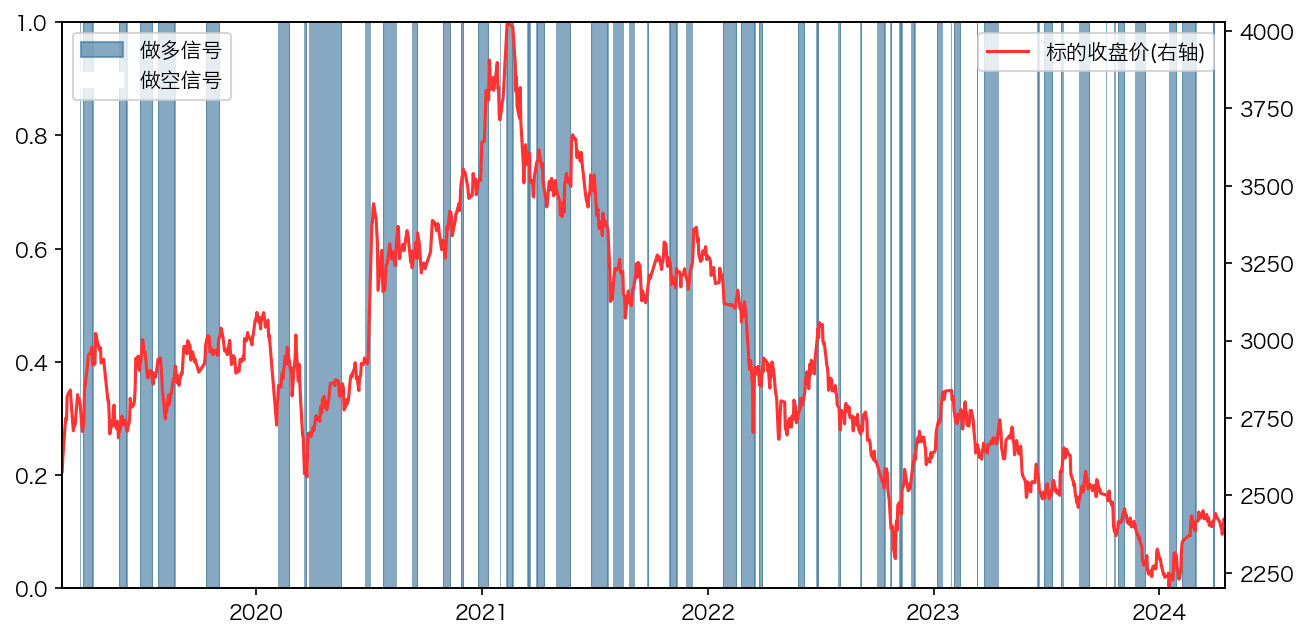

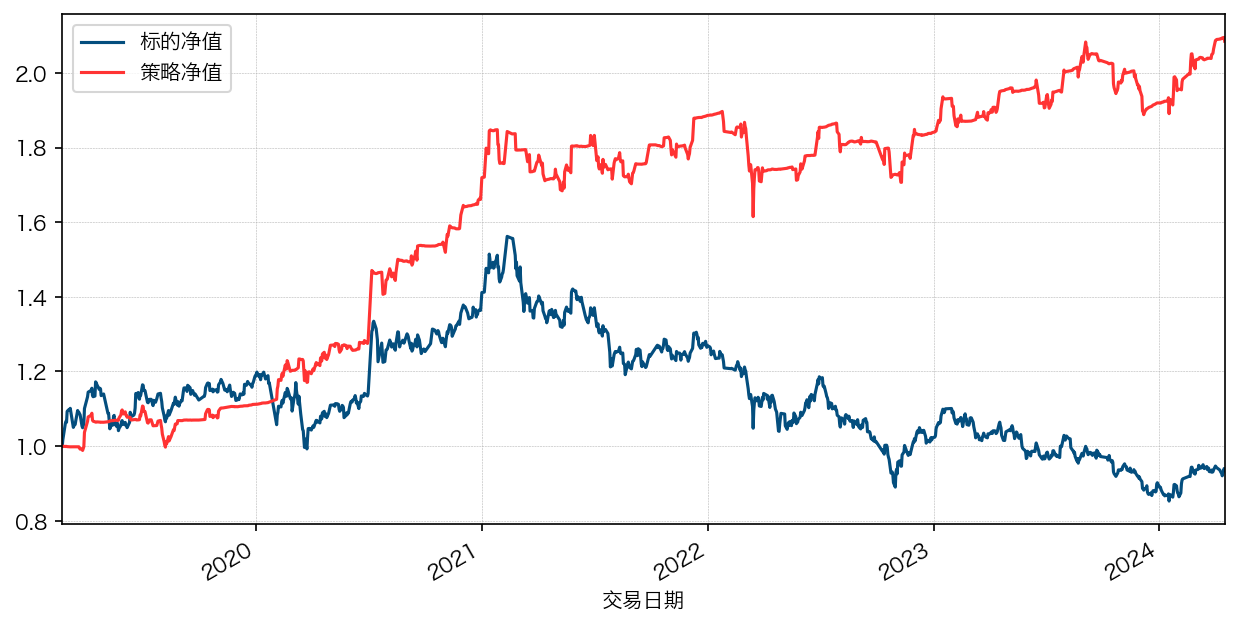


------------------- strategy effect ---------------------
annual return: 17.76%
annual std: 13.35%
sharpe ratio: 1.3304
maximum drawdown: -14.86%



In [12]:
''' CV_Skew择时 '''
rolling_days = 20
rolling_percentile = 0.8

df_position_CV = percentile_method_position(df_factor, 'CV_Skew', rolling_days, rolling_percentile)
calculate_nav(df_position_CV)
plot_signal(df_position_CV)
plot_nav_curve(df_position_CV)

strategy_effect = calculate_strategy_effect(df_position_CV, period)

annual_return = strategy_effect[0]
annual_std = strategy_effect[1]
sharpe = strategy_effect[2]
maximum_drawdown = strategy_effect[3]

print(f'\n------------------- strategy effect ---------------------\n'
      f'annual return: {annual_return * 100:.2f}%\n'
      f'annual std: {annual_std * 100:.2f}%\n'
      f'sharpe ratio: {sharpe:.4f}\n'
      f'maximum drawdown: {maximum_drawdown * 100:.2f}%\n'
      )

In [14]:
df_factor_CV_Skew = df_factor.copy()
df_factor_CV_Skew.reset_index(inplace=True)
df_factor_CV_Skew.rename(columns={'交易日期': 'datetime'}, inplace=True)
df_factor_CV_Skew = df_factor_CV_Skew[['datetime','CV_Skew']]
df_factor_CV_Skew.to_excel('/Users/tommylxt/Desktop/算法交易hw/相关系数/df_factor_CV_Skew.xlsx')
print('ok')

ok
